In [1]:
# Import libraries
import pandas as pd
import numpy as np

In [2]:
# Import 2 tables from IMDb datasets that we need
title_basics = pd.read_csv('title.basics.tsv.gz', sep='\t', header=0)
title_ratings = pd.read_csv('title.ratings.tsv.gz', sep='\t', header=0)

C:\Users\Administrator\.conda\envs\tf3.7\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
title_basics.head(3)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"


In [4]:
title_ratings.head(3)

,tconst,averageRating,numVotes
0,tt0000001,5.6,1648
1,tt0000002,6.1,198
2,tt0000003,6.5,1346


In [5]:
# Select only movies from the title_basics table
movies = title_basics[(title_basics.titleType == 'movie')].copy()

In [6]:

# Set the indicies for our 2 tables to the IMDb key for movies
movies.set_index('tconst', inplace=True)
title_ratings.set_index('tconst', inplace=True)
# Joint the 2 tables by tconst, the IMDb key for all movies
movies_with_rating = movies.join(title_ratings, how='inner')

In [7]:
# Take only the top 10,000 movies, where we rank movies by the number of votes they have received
top_10000_movies = movies_with_rating.sort_values(by='numVotes', ascending=False)[:10000]
movies_index = top_10000_movies.index

In [8]:
top_10000_movies.shape

(10000, 10)

In [9]:
top_10000_movies.head(3)

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,,,,
tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,9.3,2283767
tt0468569,movie,The Dark Knight,The Dark Knight,0,2008,\N,152,"Action,Crime,Drama",9.0,2247962
tt1375666,movie,Inception,Inception,0,2010,\N,148,"Action,Adventure,Sci-Fi",8.8,2009727


In [10]:
#!pip install IMDbPY
from tqdm import tqdm
from time import sleep
from imdb import IMDb

ia = IMDb()

In [11]:
keywords_dict = {}
for movie_index in tqdm(movies_index):
    #sleep(1)
    try:
        keywords_dict[movie_index] = ia.get_movie_keywords(movie_index[2:])['data']['keywords']
    except:
        keywords_dict[movie_index] = ''   
        
keywords = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in keywords_dict.items() ])).transpose()
keywords = keywords.apply(lambda x: ','.join(x.dropna()), axis=1)
keywords = pd.DataFrame(keywords)
keywords.rename(columns={0:'keywords'}, inplace=True)

 31%|███▏      | 3130/10000 [1:36:42<3:23:29,  1.78s/it]2020-09-19 11:08:40,804 CRITICAL [imdbpy] C:\Users\Administrator\.conda\envs\tf3.7\lib\site-packages\imdb\_exceptions.py:34: IMDbDataAccessError exception raised; args: ({'errcode': None, 'errmsg': 'None', 'url': 'https://www.imdb.com/title/tt0082158/keywords', 'proxy': '', 'exception type': 'IOError', 'original exception': URLError(TimeoutError(10060, 'A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond', None, 10060, None))},); kwds: {}
Traceback (most recent call last):
  File "C:\Users\Administrator\.conda\envs\tf3.7\lib\urllib\request.py", line 1319, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "C:\Users\Administrator\.conda\envs\tf3.7\lib\http\client.py", line 1252, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "C:\Users\Administ

In [14]:
# Save the plots to a CSV
keywords.to_csv(path_or_buf='keywords.csv')

In [15]:

# Load our keywords for the CSV
keywords = pd.read_csv('keywords.csv')
keywords.rename(columns={'Unnamed: 0':'tconst'}, inplace=True)
keywords.set_index('tconst', inplace=True)

In [16]:
 #Join to our table
movies = top_10000_movies.join(keywords, how='inner')

In [17]:

# Save our dataframe to a CSV if you don't want to re-run the loop
movies.to_csv(path_or_buf='movies_keywords.csv')

In [18]:
movies = movies[movies.keywords.notnull()]

In [19]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

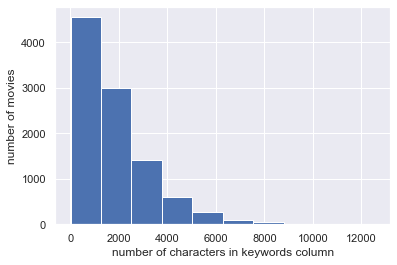

In [20]:
number_of_keyword_chars = []
for keywords in movies['keywords']:#[:10000]:
    n_chars = len(keywords)
    number_of_keyword_chars.append(n_chars)


plt.hist(number_of_keyword_chars)
plt.xlabel('number of characters in keywords column')
plt.ylabel('number of movies')
plt.show()

In [21]:
print("keywords: %.3f" %(np.mean(movies['keywords'].str.len())) )

keywords: 1796.741


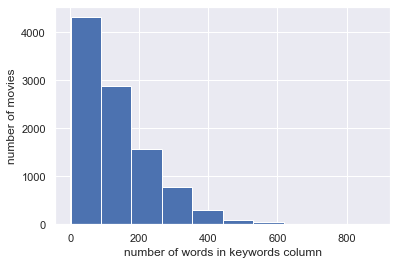

In [22]:

number_of_keywords = []
for keywords in movies['keywords']:
    n_keywords = len(keywords.split(','))
    number_of_keywords.append(n_keywords)

plt.hist(number_of_keywords)
plt.xlabel('number of words in keywords column')
plt.ylabel('number of movies')
plt.show()

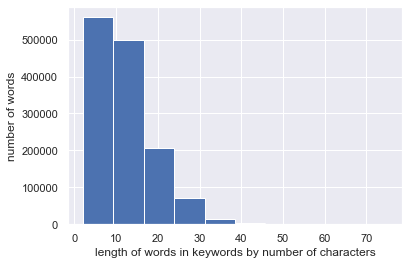

In [23]:
keyword_lengths = []
for keywords in movies['keywords']:
    keywords = keywords.split(',')
    for keyword in keywords:
        keyword_lengths.append(len(keyword))
        
plt.hist(keyword_lengths)
plt.xlabel('length of words in keywords by number of characters')
plt.ylabel('number of words')
plt.show()

In [ ]:
## Modelling

In [24]:
movies.reset_index(inplace=True)
movies = movies[['primaryTitle', 'keywords']]

In [25]:

# Processing Keywords
keywords = movies['keywords'].tolist()

from nltk.tokenize import word_tokenize
keywords = [word_tokenize(keyword.lower()) for keyword in keywords]

def no_commas(doc):
    no_commas = [t for t in doc if t!=',']
    return(no_commas)

keywords = [no_commas(kw) for kw in keywords]
processed_keywords = keywords

In [44]:
len(processed_keywords)

9989

## 1st Mode: tf-idf with cosine similarity

In [38]:

from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(processed_keywords) # create a dictionary of words from our keywords

corpus = [dictionary.doc2bow(doc) for doc in processed_keywords] 
#create corpus where the corpus is a bag of words for each document

from gensim.models.tfidfmodel import TfidfModel
tfidf = TfidfModel(corpus) #create tfidf model of the corpus

from gensim.similarities import MatrixSimilarity
# Create the similarity data structure. This is the most important part where we get the similarities between the movies.
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))

In [39]:
def movie_recommendation(movie_title, number_of_hits=5):
    movie = movies.loc[movies.primaryTitle==movie_title] # get the movie row
    keywords = movie['keywords'].iloc[0].split(',') #get the keywords as a Series (movie['keywords']),
    # get just the keywords string ([0]), and then convert to a list of keywords (.split(',') )
    query_doc = keywords #set the query_doc to the list of keywords
    
    query_doc_bow = dictionary.doc2bow(query_doc) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the movie ID and it's tf-idf value for the movie

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our movie and every other movie. 
    #So the length is the number of movies we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=movies.primaryTitle.values) #Convert to a Series
    top_hits = similarity_series.sort_values(ascending=False)[1:number_of_hits+1] 
    #get the top matching results, i.e. most similar movies; start from index 1 because every movie is most similar to itself

    #print the words with the highest tf-idf values for the provided movie:
    sorted_tfidf_weights = sorted(tfidf[corpus[movie.index.values.tolist()[0]]], key=lambda w: w[1], reverse=True)
    print('The top 5 words associated with this movie by tf-idf are: ')
    for term_id, weight in sorted_tfidf_weights[:5]:
        print(" '%s' with a tf-idf score of %.3f" %(dictionary.get(term_id), weight))
    
    # Print the top matching movies
    print("Our top %s most similar movies for movie %s are:" %(number_of_hits, movie_title))
    for idx, (movie,score) in enumerate(zip(top_hits.index, top_hits)):
        print("%d %s with a similarity score of %.3f" %(idx+1, movie, score))

In [29]:

movie_recommendation('The Shawshank Redemption', 5)

The top 5 words associated with this movie by tf-idf are: 
 'boom-shot' with a tf-idf score of 0.085
 'fresh-fish' with a tf-idf score of 0.085
 'gay-rape,1950s' with a tf-idf score of 0.085
 'killed-by-prison-guard' with a tf-idf score of 0.085
 'library-cart' with a tf-idf score of 0.085
Our top 5 most similar movies for movie The Shawshank Redemption are:
1 Stir Crazy with a similarity score of 0.073
2 Life with a similarity score of 0.071
3 Escape from Alcatraz with a similarity score of 0.069
4 Lock Up with a similarity score of 0.063
5 Birdman of Alcatraz with a similarity score of 0.061


In [40]:
def keywords_recommendation(keywords, number_of_hits):
    query_doc_bow = dictionary.doc2bow(keywords) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the movie ID and it's tf-idf value for the movie

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our movie and every other movie. 
    #So the length is the number of movies we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=movies.primaryTitle.values) #Convert to a Series
    top_hits = similarity_series.sort_values(ascending=False)[:number_of_hits] #get the top matching results, 
    # i.e. most similar movies

    # Print the top matching movies
    print("Our top %s most similar movies for the keywords %s are:" %(number_of_hits, keywords))
    for idx, (movie,score) in enumerate(zip(top_hits.index, top_hits)):
        print("%d '%s' with a similarity score of %.3f" %(idx+1, movie, score))

In [31]:
keywords_recommendation(['wrongful-imprisonment','escape-from-prison','based-on-the-works-of-stephen-king',
                         'prison', 'voice-over-narration', 'caged-bird','reference-to-fort-hancock-texas','aria'], 5)

Our top 5 most similar movies for the keywords ['wrongful-imprisonment', 'escape-from-prison', 'based-on-the-works-of-stephen-king', 'prison', 'voice-over-narration', 'caged-bird', 'reference-to-fort-hancock-texas', 'aria'] are:
1 'The Shawshank Redemption' with a similarity score of 0.148
2 'Down by Law' with a similarity score of 0.127
3 'I Am a Fugitive from a Chain Gang' with a similarity score of 0.097
4 'Diva' with a similarity score of 0.095
5 'Old Men in New Cars: In China They Eat Dogs II' with a similarity score of 0.090


In [32]:
## 2nd Model: Word counts with cosine similarity

In [33]:

from sklearn.feature_extraction.text import CountVectorizer
def get_vectors(text):
    vectorizer = CountVectorizer(text)
    X = vectorizer.fit_transform(text).toarray()
    return(X)
vectors = get_vectors(movies.keywords.tolist())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [41]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_recommender(movie_title, number_of_hits=5):
    movie_index = movies[movies.primaryTitle == movie_title].index.values[0]

    cosines = []
    for i in range(len(vectors)):
        vector_list = [vectors[movie_index], vectors[i]]
        cosines.append(cosine_similarity(vector_list)[0,1])

    cosines = pd.Series(cosines)
    index = cosines.nlargest(number_of_hits+1).index

    matches = movies.loc[index]
    for match,score in zip(matches['primaryTitle'][1:],cosines[index][1:]):
        print(match,score )

In [35]:
cosine_recommender('The Shawshank Redemption')

Kill Your Friends 0.7480938267870737
T2 Trainspotting 0.7371977490764956
Operation Finale 0.734964314950712
A Private War 0.7317388613422842
Hot Summer Nights 0.7310568037930341


## 3rd Model: Jaccard Similarity

In [42]:
def get_jaccard_sim(str1, str2):
    a = set(str1.split(','))
    b = set(str2.split(','))
    c = a.intersection(b)
    return(float(len(c)) / (len(a) + len(b) - len(c)))

def jaccard_recommender(movie_title, number_of_hits=5):
    movie = movies[movies.primaryTitle==movie_title]
    keyword_string = movie.keywords.iloc[0]

    jaccards = []
    for movie in movies['keywords']:
        jaccards.append(get_jaccard_sim(keyword_string, movie))
    jaccards = pd.Series(jaccards)
    jaccards_index = jaccards.nlargest(number_of_hits+1).index
    matches = movies.loc[jaccards_index]
    for match,score in zip(matches['primaryTitle'][1:],jaccards[jaccards_index][1:]) :
        print(match,score )

In [37]:
jaccard_recommender('The Shawshank Redemption')

Lock Up 0.06766917293233082
Boy A 0.06765676567656766
The Green Mile 0.06582633053221289
The Getaway 0.06440071556350627
The Fugitive 0.06269113149847094


In [53]:

#movies[movies.primaryTitle=='The Shawshank Redemption'].keywords.iloc[0]